In [1]:
# Import libraries
import matplotlib.pyplot as plt # Matplotlib is used for plotting
import pandas as pd             # Pandas helps organize data structures
import numpy as np              # Numpy provides mathematical functions like sqrt()
import statsmodels.formula.api as sm  # Statsmodel provides linear regression
from sklearn import metrics 
from sklearn.model_selection import KFold
import skimage.io as io # Loads and displays images
import skimage as ski 
from scipy.linalg import svd
from pycocotools.coco import COCO # Coco dataset
from sklearn.decomposition import PCA
import os



In [2]:
def predictFruit(apple, banana, orange, pineapple):
    fruit = ''
    maxV = max(apple, banana, orange, pineapple)
    
    if apple == maxV:
        fruit = 'apple.'
    elif banana == maxV:
        fruit = 'banana.'
    elif orange == maxV:
        fruit = 'orange.'
    elif pineapple == maxV:
        fruit = 'pineapple.'
    
    print("I am", round(maxV * 100, 2), "percent confident this fruit is a", fruit)
    
    if maxV - apple < 0.20 and maxV != apple:
        print("This could also be a apple (", round(apple * 100, 2), ")")
    if maxV - banana < 0.20 and maxV != banana:
        print("This could also be a banana (", round(banana * 100, 2), ")")
    if maxV - orange < 0.20 and maxV != orange:
        print("This could also be a orange (", round(orange * 100, 2), ")")
    if maxV - pineapple < 0.20 and maxV != pineapple:
        print("This could also be a pineapple (", round(pineapple * 100, 2), ")")

In [3]:
#load images location in memory

folders = os.listdir('./images/Training')
print(folders)

cols=['Apple', 'Banana', 'Orange', 'Pineapple']

list_of_series = []
imgs = []
index = 0
for folder in folders:
    filenames = os.listdir('./images/Training/' + folder)
    
    for filename in filenames:
        imgs.append('./images/Training/' + folder + '/' + filename)
        
        #Categorize each image as containing apple/banana/orange/pineapple
        
        if folder[:5] == 'Apple':
            list_of_series.append(pd.Series([1, 0, 0, 0], index=cols))
        elif folder[:6] == 'Banana':
            list_of_series.append(pd.Series([0, 1, 0, 0], index=cols))
        elif folder[:6] == 'Orange':
            list_of_series.append(pd.Series([0, 0, 1, 0], index=cols))
        elif folder[:9] == 'Pineapple':
            list_of_series.append(pd.Series([0, 0, 0, 1], index=cols))
        
        #show loading progress
        index += 1
        print(str(index) + '/ 4555', end = '\r')
        
    df = pd.DataFrame(list_of_series, columns=cols)

#Kaggle dataset has 4555 pictures

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 2', 'Apple Granny Smith', 'Banana', 'Banana Lady Finger', 'Orange', 'Pineapple', 'Pineapple Mini']


In [4]:
#create our image input matrix

nsamples = len(imgs)
nx = 100
ny = 100
ncolors = 3

imgU = np.ndarray(shape=(nsamples, nx * ny * ncolors))
index = 0

for img in imgs:
    
    #Load image from local 
    image = io.imread(img)
    
    #display image
    #plt.axis('off')
    #plt.imshow(image)
    #plt.show()
    
    #store image as a matrix of RGB floats
    imgMatrix = ski.img_as_float(image)

    #convert matrix into single dimension
    imgMatrix = imgMatrix.reshape(1, nx * ny * ncolors)
    
    #add to our ndarray
    imgU[index] = imgMatrix
    index += 1
    
    print(str(index) + '/' + str(nsamples), end = '\r')

In [86]:
print(imgU.shape)
#don't use too many components or risk blue screening
pca = PCA(n_components = 20)

US = pca.fit_transform(imgU)
Vt = pca.components_

print(US.shape, Vt.shape)


(4555, 30000)
(4555, 20) (20, 30000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(30000,)
(4555, 30000)


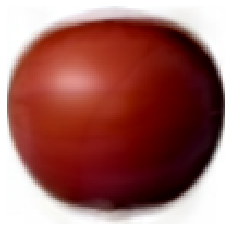

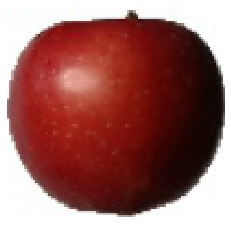

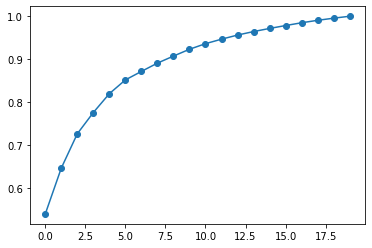

In [87]:


#reconstruct from PCA
X_hat = US @ Vt + pca.mean_

print(X_hat[0].shape)
print(X_hat.shape)

imgNew = np.ndarray(shape=(nx, ny, ncolors))

ix = 0
iy = 0
ic = 0
for i in X_hat[1]:
    imgNew[ix][iy][ic] = i
    ic += 1
    if ic >= ncolors:
        ic = 0
        iy += 1
    
    if iy >= ny:
        iy = 0
        ix += 1
        
#print(imgNew.shape)
#print(imgNew)

image = imgNew
    
plt.axis('off')
plt.imshow(image)
plt.show()

image = io.imread(imgs[1])
plt.axis('off')
plt.imshow(image)
plt.show()

S = pca.explained_variance_
plt.plot(np.cumsum(S)/np.sum(S), 'o-')
#plt.plot(S, 'o-')
plt.show()


In [6]:
#Setup dataframe
df_new = pd.DataFrame(data=US, columns=['PC{}'.format(i+1) for i in np.arange(20)])

df_new['Apple'] = df['Apple']
df_new['Banana'] = df['Banana']
df_new['Orange'] = df['Orange']
df_new['Pineapple'] = df['Pineapple']

In [7]:
#Use 5 PCs

PCS = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']

formula = 'Apple ~ 1'
for pc in PCS:
    formula += ' + ' + pc

appleModel = sm.ols(formula, data=df_new).fit()

appleHat = appleModel.params.Intercept

for pc in PCS:
    appleHat += appleModel.params[pc] * df_new[pc]
 
formula = 'Banana ~ 1'
for pc in PCS:
    formula += ' + ' + pc

bananaModel = sm.ols(formula, data=df_new).fit()

bananaHat = bananaModel.params.Intercept

for pc in PCS:
    bananaHat += bananaModel.params[pc] * df_new[pc]

formula = 'Orange ~ 1'
for pc in PCS:
    formula += ' + ' + pc

orangeModel = sm.ols(formula, data=df_new).fit()

orangeHat = orangeModel.params.Intercept

for pc in PCS:
    orangeHat += orangeModel.params[pc] * df_new[pc]

formula = 'Pineapple ~ 1'
for pc in PCS:
    formula += ' + ' + pc

pineappleModel = sm.ols(formula, data=df_new).fit()

pineappleHat = pineappleModel.params.Intercept

for pc in PCS:
    pineappleHat += pineappleModel.params[pc] * df_new[pc]
 


#MSE = np.square(np.subtract(df_new["Apple"], applehat)).mean()
#print(MSE)

In [ ]:
import random

r = list(range(nsamples))
random.shuffle(r)

for i in r:
    
    #Load image from local 
    image = io.imread(imgs[i])
    
    #display image
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    
    print("Confidence of apple:", appleHat[i])
    print("Confidence of banana:", bananaHat[i])
    print("Confidence of orange:", orangeHat[i])
    print("Confidence of pineapple:", pineappleHat[i])
    
    predictFruit(appleHat[i], bananaHat[i], orangeHat[i], pineappleHat[i])
   


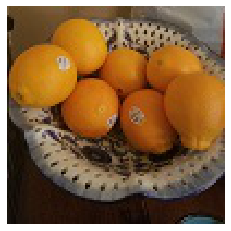

(4555, 30000)
(4555, 20) (20, 30000)


In [5]:
image = io.imread('./images/orangesResized.jpg')
    
#display image
plt.axis('off')
plt.imshow(image)
plt.show()
    
#store image as a matrix of RGB floats
imgMatrix = ski.img_as_float(image)

#convert matrix into single dimension
imgMatrix = imgMatrix.reshape(1, nx * ny * ncolors)
    
#add to our ndarray
imgU[index - 1] = imgMatrix

print(imgU.shape)
#don't use too many components or risk blue screening
pca = PCA(n_components = 20)

US = pca.fit_transform(imgU)
Vt = pca.components_

print(US.shape, Vt.shape)


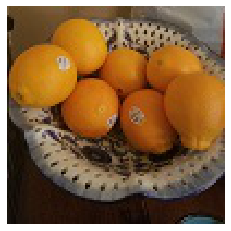

Confidence of apple: 0.3433422075039183
Confidence of banana: 0.190395367741503
Confidence of orange: 0.4447733287287272
Confidence of pineapple: 0.021489096025851473
I am 44.48 percent confident this fruit is a orange.
This could also be a apple ( 34.33 )


In [8]:
image = io.imread('./images/orangesResized.jpg')
    
#display image
plt.axis('off')
plt.imshow(image)
plt.show()

print("Confidence of apple:", appleHat[index - 1])
print("Confidence of banana:", bananaHat[index - 1])
print("Confidence of orange:", orangeHat[index - 1])
print("Confidence of pineapple:", pineappleHat[index - 1])

predictFruit(appleHat[index - 1], bananaHat[index - 1], orangeHat[index - 1], pineappleHat[index - 1])